In [5]:
%load_ext autoreload
%autoreload 2
%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [358]:
import px4tools.ulog
import pandas
import os
import pickle
import scipy.interpolate
import px4tools.version

rcParams['lines.linewidth'] = 2

In [359]:
pandas.__version__

'0.19.2'

In [360]:
px4tools.version.git_revision

'f0b3f6b5954060ca6f7c08759805468bda0fa5dd'

In [361]:
d_gyro = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/logs/01-18-17-gyro-bias.ulg',
    msg_filter='sensor_gyro',
    processing_func=lambda x: x['sensor_gyro_0'].resample('1 s').agg('mean'),
    save_path='./logs/01-18-17-gyro-bias-sensor_gyro_0.pkl',
    force_processing=False)

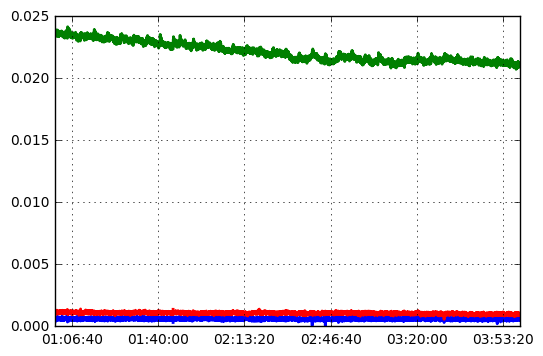

In [362]:
d_gyro['1 h': '3 h'].t_sensor_gyro_0__f_x.plot()
d_gyro['1 h': '3 h'].t_sensor_gyro_0__f_y.plot()
d_gyro['1 h': '3 h'].t_sensor_gyro_0__f_z.plot()
plt.grid()

In [363]:
d_comb = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/logs/01-18-17-gyro-bias.ulg',
    msg_filter='',
    processing_func=lambda x: x,
    save_path='./logs/01-18-17-gyro-bias-comb.pkl',
    force_processing=False)

In [364]:
d_gyro_bias = d_comb.concat(dt=1).ffill().bfill()['2 min': '60 m']

In [365]:
def plot_gyro_bias(d):
    for i, axis, color in zip([7, 8, 9], ['x', 'y', 'z'], ['r', 'g', 'b']):
        est =  getattr(d, 't_estimator_status_0__f_states_{:d}_'.format(i))
        est.plot(label=axis + ' est', style=color + '--')
        true = getattr(d, 't_sensor_gyro_0__f_{:s}'.format(axis))
        true.plot(label=axis, style=color, alpha=0.5)
    plt.gcf().autofmt_xdate()
    legend(ncol=3, loc='best')
    plt.ylabel('rad/s')
    plt.title('gyro bias')

def plot_gyro_bias_error(d):
    (d.t_estimator_status_0__f_states_7_ - d.t_sensor_gyro_0__f_x).plot(label='x', style='r')
    (d.t_estimator_status_0__f_states_8_ - d.t_sensor_gyro_0__f_y).plot(label='y', style='g')
    (d.t_estimator_status_0__f_states_9_ - d.t_sensor_gyro_0__f_z).plot(label='z', style='b')
    plt.gcf().autofmt_xdate()
    legend(ncol=3, loc='best')
    plt.title('gyro bias error')

In [366]:
def plot_accel_bias(d):
    for i, axis, color in zip([10, 11, 12], ['x', 'y', 'z'], ['r', 'g', 'b']):
        est =  getattr(d, 't_estimator_status_0__f_states_{:d}_'.format(i))
        est.plot(label=axis + ' est', style=color + '--')
        true = getattr(d, 't_sensor_accel_0__f_{:s}'.format(axis))
        if axis == 'z':
            true = pandas.Series(true + 9.8)
        true.plot(label=axis, style=color, alpha=0.5)
            
    plt.ylabel('m/s^2')
    plt.gcf().autofmt_xdate()
    legend(ncol=3, loc='best')
    plt.title('accel bias')

def plot_accel_bias_error(d):
    (d.t_estimator_status_0__f_states_10_ - d.t_sensor_accel_0__f_x).plot(label='x', style='r')
    (d.t_estimator_status_0__f_states_11_ - d.t_sensor_accel_0__f_y).plot(label='y', style='g')
    (d.t_estimator_status_0__f_states_12_ - d.t_sensor_accel_0__f_z - 9.8).plot(label='z', style='b')

(-0.02, 0.02)

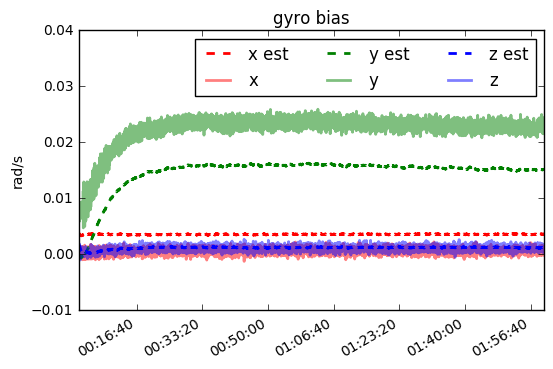

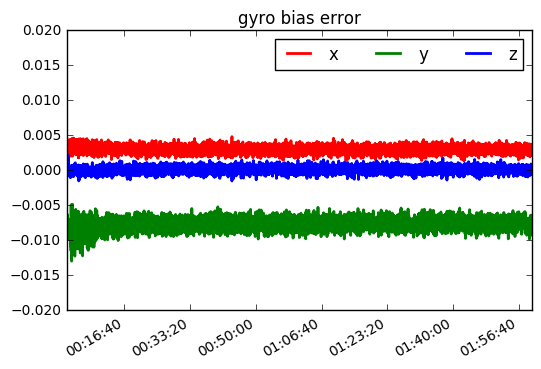

In [367]:
figure()
plot_gyro_bias(d_gyro_bias)
gca().set_ylim(-0.01, 0.04)

figure()
plot_gyro_bias_error(d_gyro_bias)
gca().set_ylim(-0.02, 0.02)

(-0.4, 0.4)

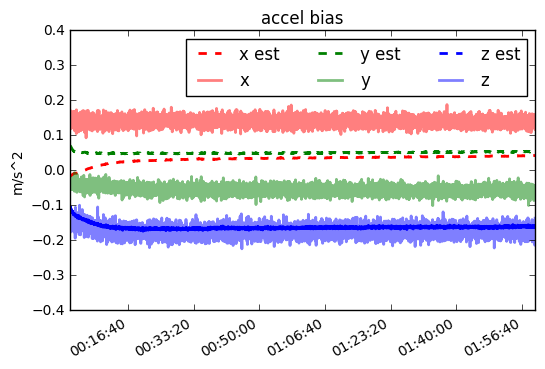

In [368]:
plot_accel_bias(d_gyro_bias)
gca().set_ylim(-0.4, 0.4)

### figure()
plot_accel_bias(d_gyro_bias)
gca().set_ylim(-0.5, 0.5)
gcf().autofmt_xdate()

figure()
plot_accel_bias_error(d_gyro_bias)
gca().set_ylim(-1, 1)
gcf().autofmt_xdate()